<a href="https://colab.research.google.com/github/benzerer/chars2vec/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment เมื่อใช้ครั้งแรก (โหลด update chars2vec จาก git เลาเอง เนื่องจากต้นฉบับมีบั๊ก เลาแก้บั๊กให้แล้ว)
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !wget https://github.com/benzerer/chars2vec/archive/refs/heads/master.zip
# !unzip master.zip
# !cp -r chars2vec\-master/chars2vec .

In [ ]:
# อันนี้คืออะไร ใช้ทำอะไรได้?? ดูนี่ --> https://medium.com/hackernoon/chars2vec-character-based-language-model-for-handling-real-world-texts-with-spelling-errors-and-a3e4053a147d

In [2]:
import chars2vec
import sklearn.decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt

# set mathtext font fallback (อันนี้เยอะกว่าปกติหน่อย)
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')
mpl.rc('mathtext', fontset='custom')
mpl.rc('mathtext', bf='TH Sarabun New')
mpl.rc('mathtext', cal='TH Sarabun New')
mpl.rc('mathtext', it='TH Sarabun New')
mpl.rc('mathtext', rm='TH Sarabun New')
mpl.rc('mathtext', sf='TH Sarabun New')
mpl.rc('mathtext', tt='TH Sarabun New')

In [3]:
# จำนวน dimension ของ vector
dim = 100

# ใช้ save / load model
path = '/content/mod'

# ทดสอบ pair
X_train = [('โอนเงิน', 'กล่อง'),
           ('กล่อง A', 'กล่อง B'),
           ('กล่อง A', 'A'),
           ('กล่องขนาด A', 'กล่อง A'),
           ('กล่อง', 'นมกล่อง'),
           ('กล้อง', 'กล่อง'),
           ('ขนม', 'กล่อง')
          ]

# คำที่เป็นสิ่งเดียวกัน ให้คะแนน 1 ต่างกันให้ 0
y_train = [0, 1, 1, 1, 0, 0, 0]

# Bag of characters
model_chars = list(set(
    char
    for tup in X_train
    for word in tup
    for char in word
    ))

# Train & save
my_c2v_model = (
    chars2vec
    .train_model(
        dim,
        X_train,
        y_train,
        model_chars
        ))

chars2vec.save_model(my_c2v_model, path)
c2v_model = chars2vec.load_model(path)

# Try to create embeddings
words = [word for tup in X_train for word in tup]
word_embeddings = c2v_model.vectorize_words(words)

# PCA เนื่องจากมี 100 dimension
projection_2d = (
    sklearn
    .decomposition
    .PCA(n_components=2)
    .fit_transform(word_embeddings)
    )

Epoch 1/200
1/1 [==============================] - 17s 17s/step - loss: 0.5000 - val_loss: 0.5027
Epoch 2/200
1/1 [==============================] - 0s 77ms/step - loss: 0.4997 - val_loss: 0.5031
Epoch 3/200
1/1 [==============================] - 0s 142ms/step - loss: 0.4993 - val_loss: 0.5036
Epoch 4/200
1/1 [==============================] - 0s 123ms/step - loss: 0.4988 - val_loss: 0.5044
Epoch 5/200
1/1 [==============================] - 0s 81ms/step - loss: 0.4982 - val_loss: 0.5053
Epoch 6/200
1/1 [==============================] - 0s 51ms/step - loss: 0.4974 - val_loss: 0.5066
Epoch 7/200
1/1 [==============================] - 0s 61ms/step - loss: 0.4964 - val_loss: 0.5082
Epoch 8/200
1/1 [==============================] - 0s 62ms/step - loss: 0.4949 - val_loss: 0.5102
Epoch 9/200
1/1 [==============================] - 0s 122ms/step - loss: 0.4927 - val_loss: 0.5127
Epoch 10/200
1/1 [==============================] - 0s 155ms/step - loss: 0.4897 - val_loss: 0.5160
Epoch 11/200
1/

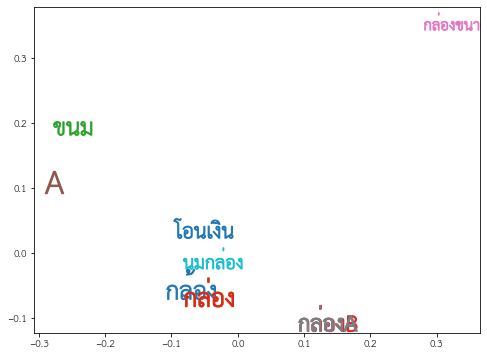

In [4]:
# ลอง Plot ดู
f = plt.figure(figsize=(8, 6))

for idx, ctx in enumerate(projection_2d):
    plt.scatter(ctx[0], ctx[1],
                marker=('$' + words[idx] + '$'),
                s=500 * len(words[idx]), 
                label=idx)

plt.show()